# 교차 검증과 그리드 서치

## 검증 세트
- 테스트 세트를 너무 많이 사용하면 모델이 테스트 세트로 학습이 될 수 있음
    - 모델 알고리즘에 사용되면 해당 테스트세트의 패턴을 저장하게 됨
    - 즉, 테스트 세트는 마지막에 한번만 사용하는 것이 좋다
- 검증세트
    - 모델의 상태(과대/과소 적합)를 파악하기 위한 데이터 세트
    - 보통 트레인 세트에서 검증세트를 분리해서 사용함
    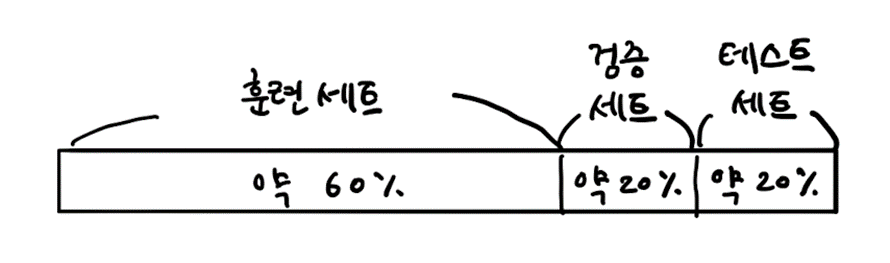

In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine-date')

In [2]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [3]:
# 트레인/테스트 세트 분리
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [4]:
# 트레인 검증 세트 분리
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [6]:
print(sub_input.shape, val_input.shape,test_input.shape)

(4157, 3) (1040, 3) (1300, 3)


In [7]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


- 훈련세트에 과대적합되어 있음

## 교차 검증

### 교차 검증
- 검증 세트를 만드느라 훈련세트가 줄었음
    - 보통 많은 데이터를 훈련에 사용할 수록 더 좋은 모델이 만들어짐
    - 그런 이유로 검증 세트를 너무 조금 떼어 놓으면 성능이 들쭉날쭉해서 불안정함
    - **교차검증사용으로 해결**
- 교차검증
    - 검증세트를 떼어 평가하는 과정을 여러번 반복
        - 이 과정에서 검증세트를 고정 시키지 않고 변경시킨다
        - 검증세트는 중복되지 않는다
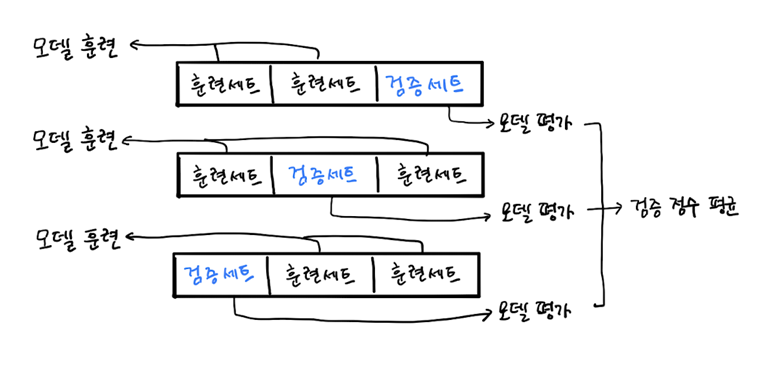
- from sklearn.model_selection import cross_validate 함수 사용
    - cross_validate(모델, 학습데이터, 타겟데이터)

In [8]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt,train_input, train_target)
scores
# cross_validate : 각 폴드별 학습시간, 검증시간, 검증점수가 담긴 dict

{'fit_time': array([0.0059998 , 0.00600052, 0.00799894, 0.00600243, 0.00599813]),
 'score_time': array([0.00100231, 0.        , 0.00100064, 0.00099993, 0.00100136]),
 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}

- 기본 5 폴드 교차 검증을 진행 함

In [9]:
# 모델의 교차검증 스코어 평균
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


- **교차검증 수행시 해당 모델에서 얻을 수 있는 최상의 성능점수를 가늠해 볼 수 있음**

- **주의**
    - cross_validate() 는 데이터를 섞어 폴드를 나누지 않는다
        - 앞에 분할할때 섞었기 때문에 다시 섞지 않아도 되긴 함
    - 데이터를 섞은 후 분할을 하고자 한다면 StratifiedKFold()함수를 사용함
        - 회귀 모델인 경우는 KFold 사용
    - n_splits=10은 몇개의 폴딩을 할 것인지 결정
    - shuffle=True 섞을것인지 결정

In [11]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt,train_input, train_target,cv=StratifiedKFold())
print(np.mean(scores['test_score']))


0.855300214703487


In [14]:
splitter = StratifiedKFold(n_splits=10,shuffle=True, random_state=42)
scores = cross_validate(dt,train_input, train_target,cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝
- 하이퍼파라미터 : 사용자 지정 파라미터(모델이 직접 세팅할 수 없어서 사용자가 세팅해야 함)
- 튜닝 방법
    1. 모델의 기본 세팅값을 이용해서 그대로 훈련
    2. 검증세트의 점수나 교차검증을 통해서 매개변수를 조금씩 바꿔봄
    - tip. 하이퍼파라미터를 한개씩 바꿔보는 것이 아니고 여러개의 매개변수를 동시에 바꿔가면서 튜닝을 해야 함
    3. 모든 경우의 수를 확인해서 for문을 돌릴 수도 있지만 많이 번거롭고, 그 기능을 해주는 함수가 마련되어 있음
        - GridSearchCV()

### GridSearchCV
- Classifier나 Regressor와 같은 알고리즘에 사용되는 하이퍼 파라미터를 순차적으로 입력하면서
    - 최적의 파라미터를 편리하게 도출할 수 있는 방법 제공  
        - (Grid는 격자라는 의미 : 촘촘하게 파라미터를 입력하면서 테스트 하는 방식)

- 즉,  
    - 머신러닝 알고리즘의 여러 하이퍼 파라미터를  
    - 순차적으로 변경하면서 최고 성능을 가지는 파라미터를 찾고자 한다면  
    - 파라미터의 집합을 만들어 순차적으로 적용하면서 최적화 수행  

- **GridSearchCV 클래스 생성자의 주요 파라미터**

    - estimator : classifier, regressor, peipeline

    - param_grid : key + 리스트 값을 가지는 딕셔너리 (estimator 튜닝을 위한 하이퍼 파라미터 )
         - key: 파라미터명, 리스트값:파라미터 값
    - scoring : 예측 성능을 측정할 평가 방법 
         - 성능 평가 지표를 지정하는 문자열
         - 예: 정확도인 경우 'accuracy'
    - cv : 교차 검증을 위해 분할되는 학습/테스트 세트의 개수
    - refit : 최적의 하이퍼 파라미터를 찾은 뒤 
        - 입력된 estimator 객체를 해당 하이퍼 파라미터로 재학습 여부
        - 디폴트 : True    


-  parmas 파라미터
    - {'하이퍼파라미터명' : [튜닝할 수치들]}

In [15]:
from sklearn.model_selection import GridSearchCV
# 하이퍼파라미터 : 'min_impurity_decrease' - 최소불순도(기본값 : 0.0)
# 튜닝 수치들 : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
params = {'min_impurity_decrease' :[0.0001, 0.0002, 0.0003, 0.0004, 0.0005] }

In [16]:
# n_jobs=-1 : cpu의 모든 성능을 다 사용
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),params,n_jobs=-1)

In [17]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [18]:
# 가장 최적의 하이퍼파라미터로 다시 훈련시킨 베스트모델
best_dt_g = gs.best_estimator_
print(best_dt_g.score(train_input, train_target))

0.9615162593804117


In [19]:
# 튜닝한 하이퍼파라미터 min_impurity_decrease 의 최적 설정값 : 0.0001
# 단, 다른 하이퍼파라미터들은 기본값일때(모델 훈련시 사용했던 값)의 결과
# 다른 하이퍼파라미터 값이 변경되면 이 하이퍼파라미터의 최적값도 변할 수 있음
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [20]:
# GridSearchCV() 는 CV를 포함하고 있음
# 즉 파라미터 조합 경우의 수 한번당 설정된  cv를 진행 - cv는 기본 5번임
# 5번의 cv 결과값 : cv_results_  속성
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [22]:
# 결과가 가장 높게 나온 회차를 argmax로 확인
best_index=np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


- **여러개의 하이퍼파라미터 튜닝**
    - 딕셔너리로 생성
    - 여러 하이퍼 파라미터에 대해 여러 값으로 모델링을 진행 후 성능을 평가해 볼 수 있다
        - 수행횟수 
            - min_impurity_decrease:9 X max_depth:15 X min_samples_split: 10 X cv:5

In [27]:
# np.arange(0.0001, 0.001, 0.0001)
# for i in range(2, 100, 10) :
#     print(i)

In [28]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [29]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [30]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [32]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


In [33]:
best_dt_g = gs.best_estimator_
best_dt_g.score(test_input, test_target)

0.8615384615384616

In [34]:
best_dt_g.score(train_input, train_target)

0.892053107562055

- 하이퍼파라미터 튜닝수 파라미터값의 간격은 정해진 규칙은 없다.
    - 조금 더 넓거나 좁은 간격으로 진행해볼 수 도 있음
- 랜덤서치
    - 매개변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링할 수 있는 확률분포 객체를 전달
       - ex. uniform, randint 등

### 랜덤 서치
- sklearn.model_selection.RandomizedSearchCV(estimator, param_distributions, *, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score=nan, return_train_score=False

In [35]:
# uniform, randint 주어진 범위에서 고르게 값을 뽑는다
from scipy.stats import uniform, randint

- 참고

In [39]:
# 균등분포
rgen = randint(0, 10,1)
rgen.rvs(10) #rvs()  표본추출(sampling)
# rgen.rvs(1000) #rvs()  표본추출(sampling)

array([ 3,  1,  1, 10,  6,  3,  5,  8,  9,  6], dtype=int64)

In [40]:
np.unique(rgen.rvs(1000), return_counts=True)
# 0~9 범위의 숫자가 거의 균등하게 sampling됨

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([110,  91, 105, 101, 107,  79, 100,  95,  95, 117], dtype=int64))

In [41]:
# uniform 도 비슷
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.3394216 , 0.89539993, 0.43089545, 0.77401724, 0.27541695,
       0.71072906, 0.91502612, 0.93083688, 0.31611674, 0.73484608])

In [42]:
np.unique(ugen.rvs(1000), return_counts=True)

(array([2.39979013e-05, 1.12995390e-03, 1.95910443e-03, 2.47612409e-03,
        2.81004276e-03, 3.22760009e-03, 3.24871540e-03, 6.30731621e-03,
        6.91309642e-03, 7.98782745e-03, 8.02743495e-03, 8.42200737e-03,
        8.51353900e-03, 9.88240438e-03, 1.29265761e-02, 1.43207150e-02,
        1.49873730e-02, 1.68703819e-02, 1.70317149e-02, 1.75447073e-02,
        1.94387426e-02, 2.03351860e-02, 2.21687415e-02, 2.47620754e-02,
        2.66801433e-02, 2.82009486e-02, 2.85431758e-02, 2.92037239e-02,
        3.01563887e-02, 3.02697665e-02, 3.21505867e-02, 3.36262704e-02,
        3.55114458e-02, 3.56621420e-02, 3.66931689e-02, 3.73137687e-02,
        4.01763080e-02, 4.05011955e-02, 4.05248795e-02, 4.26737970e-02,
        4.47431177e-02, 4.59009753e-02, 4.63370369e-02, 4.74045320e-02,
        4.80490107e-02, 4.88589071e-02, 4.93683395e-02, 5.02463883e-02,
        5.11325951e-02, 5.19243378e-02, 5.25055507e-02, 5.27764659e-02,
        5.31332964e-02, 5.67800895e-02, 5.70020059e-02, 5.877152

- 파라미터 값으로 확률분포 객체를 전달 

In [47]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [48]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),params,
                        n_iter=100,n_jobs=-1, random_state=42)
rs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027E30B806D0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027E30CE3DF0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027E30C659A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027E30CE3100>},
                   random_state=42)

In [49]:
print(rs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [50]:
print(np.max(rs.cv_results_['mean_test_score']))

0.8695428296438884


In [51]:
best_dt_r = rs.best_estimator_
best_dt_r.score(test_input, test_target)

0.86

In [52]:
best_dt_r = rs.best_estimator_
best_dt_r.score(train_input, train_target)

0.8928227823744468